This notebook is meant for summarizing my research results, specifically for algorithms that use an explicit clustering of neurons into K classes, and based on GLMs

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

Section 1: Assign cell classes based on brain region, corical layer, and inh/exc

Before Feb 8

These next two cells grab data from the Ephys Observatory dataset, here using drifting gratings stimulus presentations.

Text(0.5,0,'neuron')

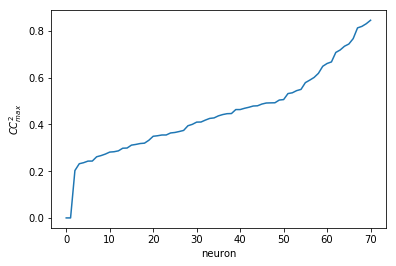

In [2]:
# cell type information on VISp neurons from 1 mouse
D = np.load('cell_types71.npz')
cell_types = D['cell_types']

# drifting grating stimuli and response data
D = np.load('drifting_gratings_data.npz')
binned_spikes = D['binned_spikes']
stim = D['stim_array']
CCmaxs = D['CCmaxs']
bin_len = 0.01
plt.plot(np.square(np.sort(CCmaxs)))
plt.ylabel('$CC_{max}^2$')
plt.xlabel('neuron')

In [3]:
# np.savetxt('spikes1.txt',binned_spikes[ord_idxs[0]],fmt='%.2i')
# np.savetxt('spikes2.txt',binned_spikes[ord_idxs[-1]],fmt='%.2i')
# np.savetxt('stim.txt',np.argmax(mod_stim,axis=0),fmt='%.2i')

In [4]:
#these are the cells (and corresponding cell types) that I preselected based on their CCmax values
ord_idxs = np.argsort(CCmaxs)[-30:]
ord_idxs = np.concatenate((ord_idxs[:-12],ord_idxs[-11:-6],ord_idxs[-4:]))
ord_types = cell_types[ord_idxs] 

types,counts = np.unique(cell_types[ord_idxs],return_counts=True)
print 'unique types: ', types
print 'frequencies:', counts

unique types:  ['exc_VISp_1' 'exc_VISp_5' 'inh_VISp_1' 'inh_VISp_4' 'inh_VISp_5']
frequencies: [ 3  2  4  2 16]


This next cell defines the model that is used to fit neurons with independent parameter sets:
$x_i(t) \sim Poisson(e^{[\vec s(t),...,\vec s(t-d_1+1)] \cdot [\vec F_i(0),...,\vec F_i(d_1)] + [x_i(t-1),...,x_i(t-d_2)] \cdot [W_i(0),...,W_i(d_2)] + b_i})$

Where $x_i(t)$ is the spike count of neuron i in time bin t, $\vec s(t)$ is the stimulus vector at time t, $\vec F_i(\tau)$ is the vector of stimulus filter coefficients for time $\tau$, $W_i(\tau)$ is the self interaction filter at time $\tau$, and $b_i$ is a constant bias term.

In [33]:

#helper functions for fitting GLM models
from scipy.stats import pearsonr
from scipy.misc import factorial

def construct_Xdsn(flat_stimulus, binned_spikes, d):
    T = binned_spikes.size # T is number of time bins
    sh = flat_stimulus.shape # M is the size of a stimulus
    if len(sh)==1:
        M = 1
        T1 = sh[0]
        flat_stimulus = np.expand_dims(flat_stimulus,axis=0)
    else:
        (M,T1) = sh   
    
    assert T==T1, "arrays have different number of time samples"
    d1,d2 = d
    dmax = max(d)
    binned_spikes = np.concatenate((np.zeros((dmax,)),binned_spikes))
    flat_stimulus = np.concatenate((np.zeros((M,dmax)),flat_stimulus),axis=1)
    T = binned_spikes.size
    X_dsn = np.ones((T-dmax,M*d1+d2+1))
    for t in range(T-dmax):
        X_dsn[t,:M*d1] = np.flip(flat_stimulus[:,t+dmax+1-d1:t+dmax+1],axis=1).reshape((1,-1))  #stimulus inputs
        X_dsn[t,M*d1:-1] = np.flip(binned_spikes[t+dmax-d2:t+dmax],axis=0).reshape((1,-1)) #spike inputs
    return X_dsn

def fit_GLM(stim,spks,d,val_stim=None,val_spks=None,trial_inds=None,cond_inds=None,val_trial_inds=None,val_cond_inds=None,trial_len=None):
    d1,d2 = d
    dmax = max(d)
    y = spks.reshape([-1,1])
    model =  sm.GLM(y,construct_Xdsn(stim,spks,d),family = sm.families.Poisson())
    m_it = 200 #24
    model_results = model.fit(maxiter=m_it)
#     print model_results.fit_history['iteration']
    conved = m_it!=model_results.fit_history['iteration']
    p = model_results.params
    se = model_results.bse
    b = p[-1]
    bse = se[-1]
    stim_filt = p[:-1-d2].reshape([-1,d1])
    stim_se = se[:-1-d2]
    spk_filt = p[-1-d2:-1]
    spk_se = se[-1-d2:-1]
    
    if trial_len is not None:
        num_conds = np.unique(cond_inds).size
        mean_resps = np.empty((trial_len,num_conds))
        for i in range(num_conds):
            for t in range(trial_len):
                mean_resps[t,i] = np.mean(spks[trial_inds[cond_inds==i]+t])

        N_samps = 30
        exp_resps = np.zeros((trial_len,num_conds))
        for n in range(N_samps):
            sim_spks,_ = sim_GLM(stim, stim_filt, spk_filt, b)
            for i in range(num_conds):
                for t in range(trial_len):
                    exp_resps[t,i] += np.mean(sim_spks[trial_inds[cond_inds==i]+t])
        exp_resps /= N_samps
        train_corr = pearsonr(mean_resps.reshape([-1,1]),exp_resps.reshape([-1,1]))[0]
    else:
        train_corr = None

#     plt.plot(mean_resps.reshape([-1,1]))
#     plt.plot(exp_resps.reshape([-1,1]))
    train_nnll = -model_results.llf/(spks.shape[-1]-dmax)
    dev = model_results.deviance
    
#     print dev, 2*(np.sum(-y+y*np.log(y+1e-20)-np.log(factorial(y)))-model_results.llf)
    if val_stim is not None:
        val_model = sm.GLM(val_spks.reshape([-1,1]),construct_Xdsn(val_stim,val_spks,d),family = sm.families.Poisson())
        val_nnll = -val_model.loglike(p)/(spks.shape[-1]-dmax)
        smooth_val_spks = np.convolve(val_spks,filt,mode='same')
        val_corr = pearsonr(val_model.predict(p),smooth_val_spks)[0]
        return stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr, val_nnll, val_corr, dev, conved
    return stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr, dev, conved

def sim_GLM(stim, stim_filt, spk_filt, offset,noise_amp=None,noise_len=None,drop_rate = None, drop_len = None):
    d = (stim_filt.shape[-1], spk_filt.size)
    T = stim.shape[1]
    spks = np.zeros((T,)) # starts at time step d
    rate = np.zeros((T,))
    if noise_amp is not None:
        noise_sig = np.random.normal(loc=0.0,size=(T,))
        if noise_len>0:
            t_filt = np.arange(-2*noise_len,2*noise_len+1)
            filt = np.exp(-np.square(t_filt)/(noise_len**2*2))
            noise_sig = np.convolve(noise_sig,filt,mode='same')
        noise_sig = noise_amp*noise_sig/np.sqrt(np.mean(np.square(noise_sig)))
    for i in range(max(d),T):
        rate[i] = np.exp((np.flip(stim_filt,-1).reshape(1,-1)).dot((stim[:,i-d[0]+1:i+1].reshape(-1,1)))+np.flip(spk_filt,0).dot(spks[i-d[1]:i])+offset)
        rate[i] = min(10,rate[i])
        if noise_amp is not None:
            rate[i] = max(0,rate[i]+noise_sig[i])
        if drop_rate is None:
            spks[i] = np.random.poisson(rate[i])
        else:
            if drop_len is None:
                spks[i] = np.random.poisson(rate[i])*(np.random.uniform()>drop_rate)
            else:
                spks[i] = np.random.poisson(rate[i])
                if (np.random.uniform()<drop_rate/drop_len):
                    spks[max(0,i+1-drop_len):i+1] = 0
    return spks, rate



This next cell expands the stimulus representation to a 1-hot encoding for unique combinations of experimental variables. Specifically,
\begin{equation}
  s^{(exp)}_j(t) =
    \begin{cases}
      1 & \text{if $\vec s(t)$ is the $j^{th}$ unique stimulus condition at time $t$}\\
      0 & \text{otherwise}
    \end{cases}       
\end{equation}


In [6]:
conds = np.unique(stim,axis=1)  
mod_stim = np.zeros((conds.shape[1],stim.shape[1]))
for t in range(stim.shape[1]):
    ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
    mod_stim[ind,t] = 1

In [7]:
# fit the model with a scalar stimulus filter and a 30 sample self interaction filter
d=[1,30]
stim_filt_fit, spk_filt_fit, b_fit, stim_se, spk_se, b_se, _, _, _, _ = fit_GLM(mod_stim,binned_spikes[ord_idxs[-1],:],d)


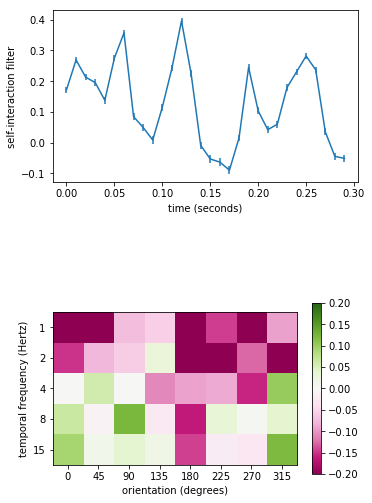

In [8]:
fig,(ax1,ax2) = plt.subplots(nrows=2)
ax1.errorbar(np.arange(d[1])*bin_len,spk_filt_fit,yerr=spk_se)
ax1.set_ylabel('self-interaction filter')
ax1.set_xlabel('time (seconds)')
im=ax2.imshow(stim_filt_fit[1:].reshape(5,8),cmap='PiYG',vmin=-0.2,vmax=0.2)
fig.colorbar(im,ax=ax2)
ax2.set_yticks(range(5))
ax2.set_yticklabels(np.unique(stim[0,:])[1:])
ax2.set_ylabel('temporal frequency (Hertz)')
ax2.set_xticks(range(8))
ax2.set_xticklabels(np.unique(stim[2,:])[1:])
ax2.set_xlabel('orientation (degrees)')
fig.tight_layout()
fig.set_size_inches(5,h=8)

From the stimulus filter, you can see that the cell prefers high frequency stimuli, with an orientation near 0 degrees. However, because I'm just specifying the condition and not providing temporal information, the preference for 15Hz stimuli is encoded in the self-interaction filter. I've tried to avoid this by providing inputs that are sinusoids of the appropriate frequencies, and I think phases, but I don't know enough about the stimuli (multiplexed with the 1-hot encoding), but this does not seem to help.

(0, 1)

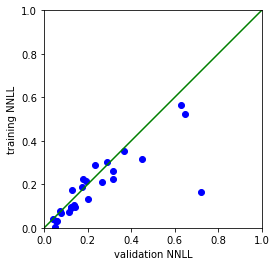

In [9]:
#these are the results from fitting the 30 cells with the highest CCmax
results_sm = np.load('drifting_gratings_indivfit1.npz') #fitted using statsmodels code above
lims = [0,1]
plt.plot(results_sm['val_nnlls'],results_sm['train_nnlls'],'bo')
plt.ylabel('training NNLL')
plt.xlabel('validation NNLL')
plt.plot(lims,lims,'g')
plt.axis('square')
plt.xlim(lims)
plt.ylim(lims)

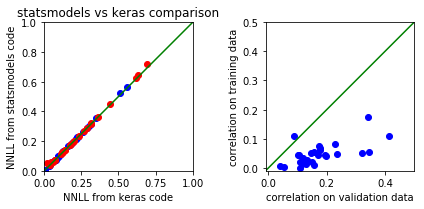

In [10]:
# here, I'm comparing to the result I get with my keras code (too unweildy for this doc)
results_ker = np.load('drifting_gratings_indivfit1_keras.npz') #fitted using keras code
lims = [0,1]
fig,(ax1,ax2) = plt.subplots(ncols=2)
ax1.plot(results_ker['train_losses'],results_sm['train_nnlls'],'bo')
ax1.plot(results_ker['val_losses'],results_sm['val_nnlls'],'ro')
ax1.plot(lims,lims,'g')
ax1.axis('square')
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.set_ylabel('NNLL from statsmodels code')
ax1.set_xlabel('NNLL from keras code')
ax1.set_title('statsmodels vs keras comparison')

lims = [-0.01,0.5]
ax2.plot(results_ker['val_corrs'],results_ker['train_corrs'],'bo')
ax2.plot(lims,lims,'g')
ax2.axis('square')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_ylabel('correlation on training data')
ax2.set_xlabel('correlation on validation data')
fig.tight_layout()

The comparison seems pretty good - one thing this isn't showing however, is one cell that had an infinite loss using statsmodels, and a fairly normal one using keras. In my understanding, the main difference is that sm uses an IRLS solver, and keras uses gradient descent.

The correlation measure to me is confusing - the validation score should never be better. I suspect it may have something to do with my split of the dataset - there are three 60-second periods of drifting gratings, interspersed with two 100-second periods of a grey screen. Exactly how much of each I pick might make the validation data easier to predict; or it could  have to do with latent states affecting the spiking.

I have been working on the shared parameters model, but the design matrix for a GLM solver grows in size with the number of cells, squared. This is causing problems for the statsmodels GLM solver, so I've been trying to get it working for very small sizes so that I can compare to my keras solver (for shared parameters), which gets around building the full design matrix.

Below, the the losses for the shared vs independent parameter models are compared

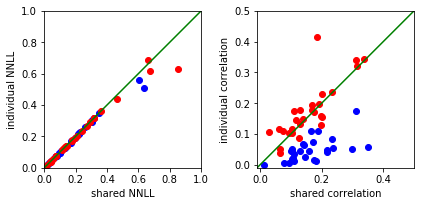

In [11]:
results_shared = np.load('driftinggs_shared_run1.npz')

lims = [0,1]
fig,(ax1,ax2) = plt.subplots(ncols=2)
ax1.plot(results_shared['train_losses'],results_ker['train_losses'],'bo')
ax1.plot(results_shared['val_losses'],results_ker['val_losses'],'ro')
ax1.plot(lims,lims,'g')
ax1.axis('square')
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.set_xlabel('shared NNLL')
ax1.set_ylabel('individual NNLL')

lims = [-0.01,0.5]
ax2.plot(results_shared['train_corrs'],results_ker['train_corrs'],'bo')
ax2.plot(results_shared['val_corrs'],results_ker['val_corrs'],'ro')
ax2.plot(lims,lims,'g')
ax2.axis('square')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_xlabel('shared correlation')
ax2.set_ylabel('individual correlation')
fig.tight_layout()

Below, I contrast with a model that has no self-interaction filter. It seems fairly clear that the filter improves performance, especially generalizability

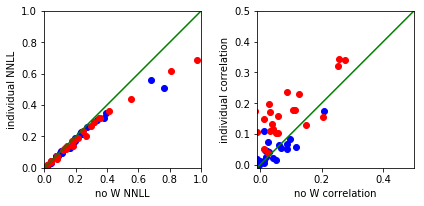

In [12]:
results_noW = np.load('driftinggs_noW_run1.npz')

lims = [0,1]
fig,(ax1,ax2) = plt.subplots(ncols=2)
ax1.plot(results_noW['train_losses'],results_ker['train_losses'],'bo')
ax1.plot(results_noW['val_losses'],results_ker['val_losses'],'ro')
ax1.plot(lims,lims,'g')
ax1.axis('square')
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.set_xlabel('no W NNLL')
ax1.set_ylabel('individual NNLL')

lims = [-0.01,0.5]
ax2.plot(results_noW['train_corrs'],results_ker['train_corrs'],'bo')
ax2.plot(results_noW['val_corrs'],results_ker['val_corrs'],'ro')
ax2.plot(lims,lims,'g')
ax2.axis('square')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_xlabel('no W correlation')
ax2.set_ylabel('individual correlation')
fig.tight_layout()

Week of Feb 15

I switched the train/val split to be a random selection of samples instead of a slice. I also smoothed the spike counts before evaluating the correlation. The following results are the same as above, but with these changes.

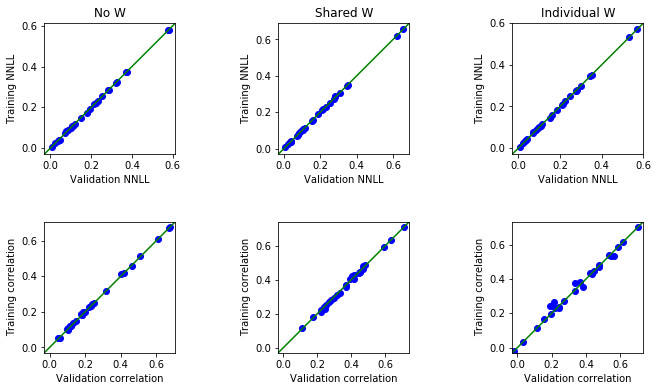

In [13]:
results_indiv = np.load('drifting_gratings_indivfit2.npz')
results_shared = np.load('driftinggs_shared_run2.npz')
results_noW = np.load('driftinggs_noW_run2.npz')
fig,axes = plt.subplots(ncols=3,nrows=2)

ax = axes[0,0]
(x,y) = (results_noW['val_losses'],results_noW['train_losses'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('No W')
ax.set_xlabel('Validation NNLL')
ax.set_ylabel('Training NNLL')

ax = axes[1,0]
(x,y) = (results_noW['val_corrs'],results_noW['train_corrs'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Validation correlation')
ax.set_ylabel('Training correlation')

ax = axes[0,1]
(x,y) = (results_shared['val_losses'],results_shared['train_losses'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Shared W')
ax.set_xlabel('Validation NNLL')
ax.set_ylabel('Training NNLL')

ax = axes[1,1]
(x,y) = (results_shared['val_corrs'],results_shared['train_corrs'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Validation correlation')
ax.set_ylabel('Training correlation')

ax = axes[0,2]
(x,y) = (results_indiv['val_losses'],results_indiv['train_losses'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Individual W')
ax.set_xlabel('Validation NNLL')
ax.set_ylabel('Training NNLL')

ax = axes[1,2]
(x,y) = (results_indiv['val_corrs'],results_indiv['train_corrs'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Validation correlation')
ax.set_ylabel('Training correlation')


fig.tight_layout()
fig.set_size_inches(10,6)

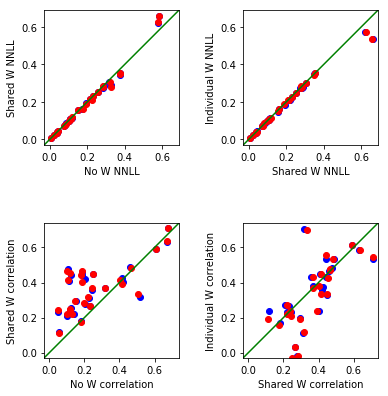

In [14]:
fig,axes = plt.subplots(ncols=2,nrows=2)

ax = axes[0,0]
(x1,y1) = (results_noW['train_losses'],results_shared['train_losses'])
(x2,y2) = (results_noW['val_losses'],results_shared['val_losses'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1,'bo')
ax.plot(x2,y2,'ro')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('No W NNLL')
ax.set_ylabel('Shared W NNLL')

ax = axes[1,0]
(x1,y1) = (results_noW['train_corrs'],results_shared['train_corrs'])
(x2,y2) = (results_noW['val_corrs'],results_shared['val_corrs'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1,'bo')
ax.plot(x2,y2,'ro')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('No W correlation')
ax.set_ylabel('Shared W correlation')

ax = axes[0,1]
(x1,y1) = (results_shared['train_losses'],results_indiv['train_losses'])
(x2,y2) = (results_shared['val_losses'],results_indiv['val_losses'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1,'bo')
ax.plot(x2,y2,'ro')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Shared W NNLL')
ax.set_ylabel('Individual W NNLL')

ax = axes[1,1]
(x1,y1) = (results_shared['train_corrs'],results_indiv['train_corrs'])
(x2,y2) = (results_shared['val_corrs'],results_indiv['val_corrs'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1,'bo')
ax.plot(x2,y2,'ro')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Shared W correlation')
ax.set_ylabel('Individual W correlation')


fig.tight_layout()
fig.set_size_inches(6,6)

These next few cells specifically look at the relationship between the wacky 15 Hz self-interaction filters and the presence of 15 Hz content in the spiking response. It seems like the cells that respond very strongly to the 15 Hz signal (24, 26, 10, 14) do have wierd self interaction filters that indicate a 15 Hz resonance. It is worth noting that cells that respond less strongly (0, 4, 6, 13) have more normal looking self interaction filters, with less obvious contamination from the 15 Hz stimulus.

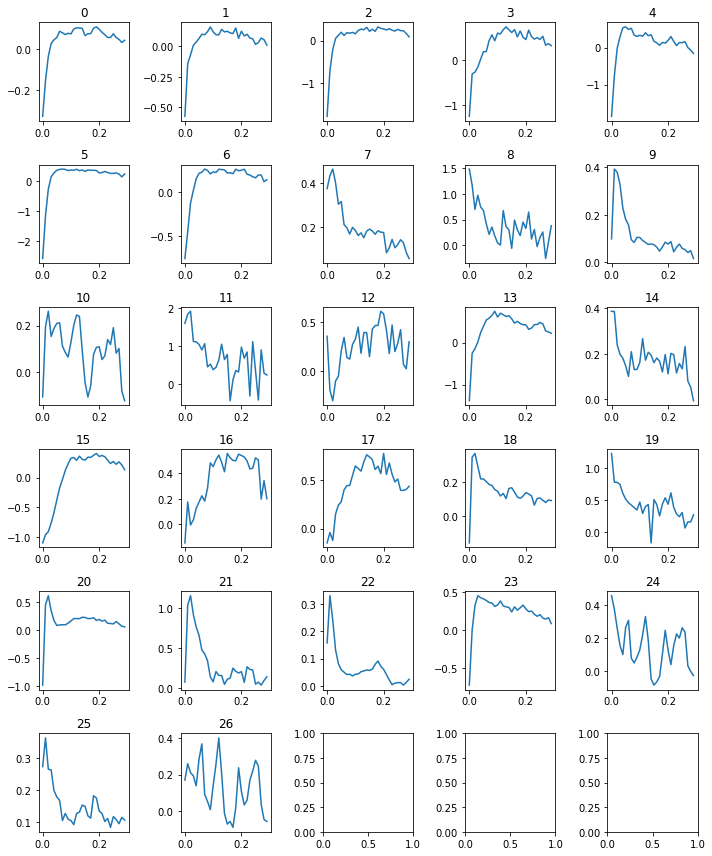

In [15]:
nr,nc = 6,5
fig,axes = plt.subplots(nrows=nr,ncols=nc)
W = results_indiv['W']
t = np.arange(d[1])*bin_len
for i in range(W.shape[0]):
    ax = axes[i/nc,i%nc]
    ax.plot(t,W[i,:])
    ax.set_title(i)
    
fig.set_size_inches(w=10,h=12)
fig.tight_layout()

In [16]:
freq = 4 #hz
F = np.fft.fft(np.compress(stim[0,:]==freq,binned_spikes[ord_idxs,:],axis=1),axis=1,norm='ortho')
# F = np.fft.fft(binned_spikes[ord_idxs,:],axis=1)
print F.shape

(27, 23798)


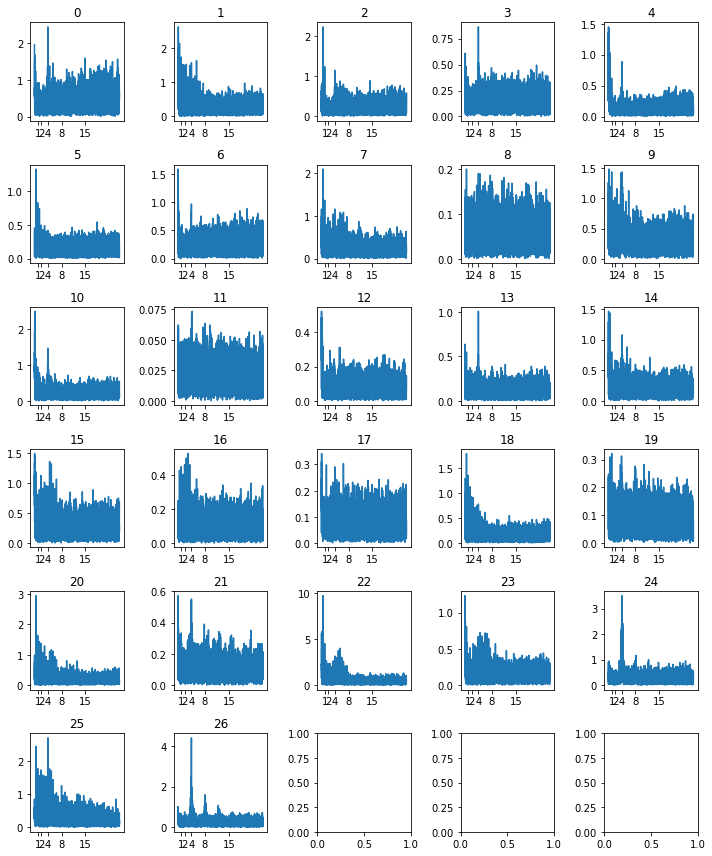

In [17]:
fs = 1.0/bin_len
fc = 25
ind = int(fc/fs*F.shape[1])
f_ax = np.arange(F.shape[1])*fs/F.shape[1]

nr,nc = 6,5
fig,axes = plt.subplots(nrows=nr,ncols=nc)
for i in range(W.shape[0]):
    ax = axes[i/nc,i%nc]
    ax.plot(f_ax[10:ind],np.abs(F)[i,10:ind].T)
    ax.set_title(i)
    ax.set_xticks([1,2,4,8,15])
    
fig.set_size_inches(w=10,h=12)
fig.tight_layout()


# plt.axis('tight')

Week of Feb 22

In an attempt to avoid the contamination of the self interaction filters with stimulus response properties, I used a stimulus representation and filter that allows an arbitrary temporal response to each stimulus condition, assuming (as led to by Josh S.) that the trials are identical. i.e.

\begin{equation}
  s^{(start)}_j(t) =
    \begin{cases}
      1 & \text{if $\vec s(t)$ is the $j^{th}$ unique stimulus condition and $\vec s(t) \neq \vec s(t-1)$}\\
      0 & \text{otherwise}
    \end{cases}       
\end{equation}

This was used with a stimulus filter that is 2s long (the length of each drifting gratings trial).

Unfortunately, the contamination is still present, although the filters appear to have the frequency content that we expect. Motivated by this, I tried a sinusoid based approach again, with a constant term and more harmonics, but the contamination was still present (results not shown here).

To be precise, this stimulus encoding uses a scalar stimulus filter and the stimulus is designed as such: Let j(t) be the index of the unique stimulus condition $\vec s(t)$. Take K = 3 harmonics, L = 2*K+1.

\begin{equation}
\begin{aligned}
&s^{(sinusoids)}_{L*j(t)}(t) = 1 \\
&\forall k \in {1,...,K} \\
&s^{(sinusoids)}_{L*j(t)+2k-1}(t) = \cos(2 \pi kf(t) (t-t_0)) \\
&s^{(sinusoids)}_{L*j(t)+2k}(t) = \sin(2 \pi kf(t) (t-t_0)) \\
&s^{(sinusoids)}_{i}(t) = 0 \text{ for all other i}
\end{aligned}
\end{equation}

where $t_0$ is the time that the trial started.

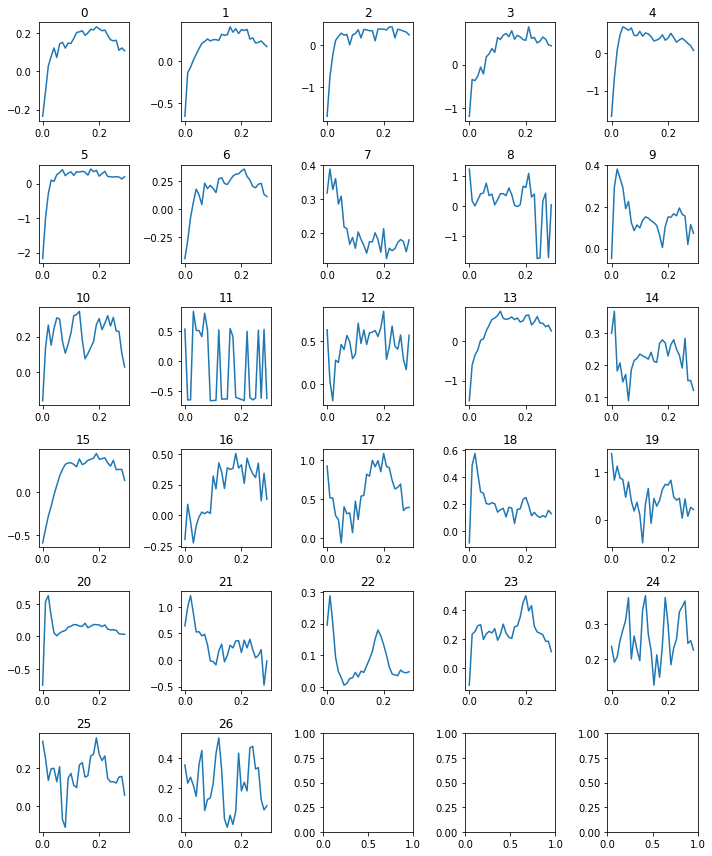

In [18]:
results_indiv = np.load('drifting_gratings_indivfit_longstimfilt.npz')
nr,nc = 6,5
fig,axes = plt.subplots(nrows=nr,ncols=nc)
W = results_indiv['W']
t = np.arange(d[1])*bin_len
for i in range(W.shape[0]):
    ax = axes[i/nc,i%nc]
    ax.plot(t,W[i,:])
    ax.set_title(i)
    
fig.set_size_inches(w=10,h=12)
fig.tight_layout()

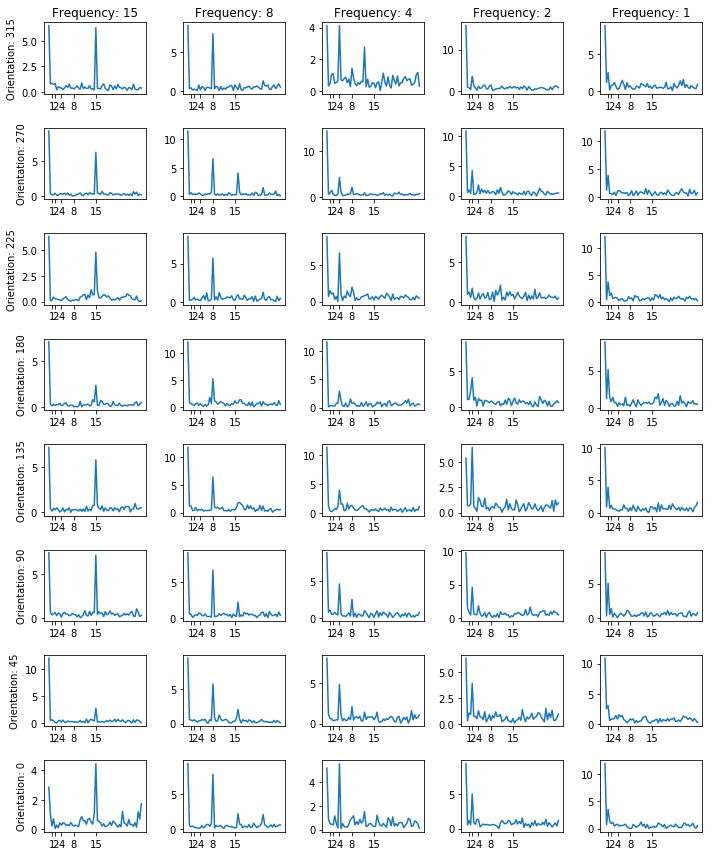

In [19]:
nr,nc = 8,5
fig,axes = plt.subplots(nrows=nr,ncols=nc)
F = results_indiv['F']
F = np.fft.fft(F,axis=2,norm='ortho')
f_ax = np.arange(F.shape[2])*fs/F.shape[2]
t = np.arange(30)*bin_len
for j in range(1,F.shape[1]):
    i=j-1
    ax = axes[i%nr,i/nr]
#     ax.plot(t,F[-1,i,:30])
    ax.plot(f_ax[:60],np.abs(F[-1,i,:60]))
    if i%nr==0:
        ax.set_title('Frequency: ' +str(conds[0,-j]))
    if i/nr==0:
        ax.set_ylabel('Orientation: ' +str(conds[2,-j]))
    ax.set_xticks([1,2,4,8,15])
    
fig.set_size_inches(w=10,h=12)
fig.tight_layout()

Based on the validation metrics being too good, and decreasing model flexibility seemingly leading to decreased training accuracy, I changed the train/val split to correspond to the 3 minute-long experimental blocks (ignoring the 100s blank screen intervals). Doing it this way does indicate some degree of overfitting, meaning that the old (random) split was not appropriate validation.

Below is the same analysis that I did before, (still 1-hot encoding) but with the new train/val split.

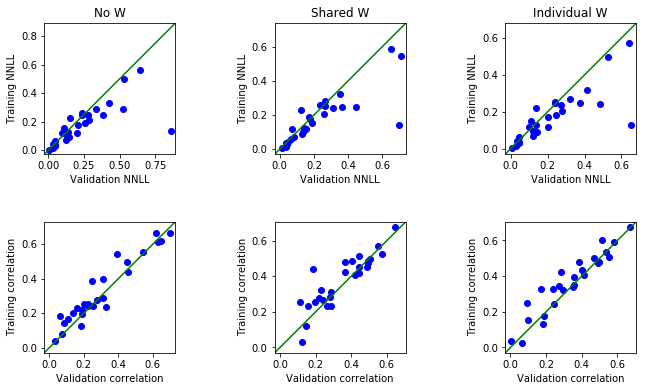

In [20]:
results_indiv = np.load('drifting_gratings_indivfit4.npz')
results_shared = np.load('driftinggs_shared_run3.npz')
results_noW = np.load('driftinggs_noW_run3.npz')
fig,axes = plt.subplots(ncols=3,nrows=2)

ax = axes[0,0]
(x,y) = (results_noW['val_losses'],results_noW['train_losses'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('No W')
ax.set_xlabel('Validation NNLL')
ax.set_ylabel('Training NNLL')

ax = axes[1,0]
(x,y) = (results_noW['val_corrs'],results_noW['train_corrs'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Validation correlation')
ax.set_ylabel('Training correlation')

ax = axes[0,1]
(x,y) = (results_shared['val_losses'],results_shared['train_losses'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Shared W')
ax.set_xlabel('Validation NNLL')
ax.set_ylabel('Training NNLL')

ax = axes[1,1]
(x,y) = (results_shared['val_corrs'],results_shared['train_corrs'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Validation correlation')
ax.set_ylabel('Training correlation')

ax = axes[0,2]
(x,y) = (results_indiv['val_losses'],results_indiv['train_losses'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Individual W')
ax.set_xlabel('Validation NNLL')
ax.set_ylabel('Training NNLL')

ax = axes[1,2]
(x,y) = (results_indiv['val_corrs'],results_indiv['train_corrs'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Validation correlation')
ax.set_ylabel('Training correlation')


fig.tight_layout()
fig.set_size_inches(10,6)

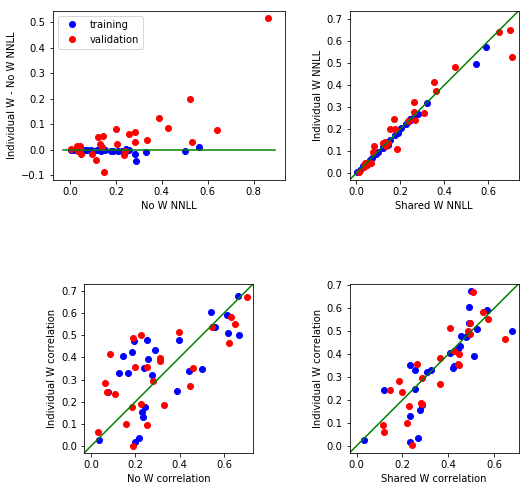

In [21]:
fig,axes = plt.subplots(ncols=2,nrows=2)

ax = axes[0,0]
(x1,y1) = (results_noW['train_losses'],results_indiv['train_losses'])
(x2,y2) = (results_noW['val_losses'],results_indiv['val_losses'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
# ax.plot(x1,y1,'bo')
# ax.plot(x2,y2,'ro')
# ax.plot(lims,lims,'g')
# ax.axis('square')
ax.plot(x1,y1-x1,'bo')
ax.plot(x2,y2-x1,'ro')
ax.plot(lims,[0,0],'g')
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.set_xlabel('No W NNLL')
ax.set_ylabel('Individual W - No W NNLL')
ax.legend(['training','validation'])

ax = axes[1,0]
(x1,y1) = (results_noW['train_corrs'],results_indiv['train_corrs'])
(x2,y2) = (results_noW['val_corrs'],results_indiv['val_corrs'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1,'bo')
ax.plot(x2,y2,'ro')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('No W correlation')
ax.set_ylabel('Individual W correlation')

ax = axes[0,1]
(x1,y1) = (results_shared['train_losses'],results_indiv['train_losses'])
(x2,y2) = (results_shared['val_losses'],results_indiv['val_losses'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1,'bo')
ax.plot(x2,y2,'ro')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Shared W NNLL')
ax.set_ylabel('Individual W NNLL')

ax = axes[1,1]
(x1,y1) = (results_shared['train_corrs'],results_indiv['train_corrs'])
(x2,y2) = (results_shared['val_corrs'],results_indiv['val_corrs'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1,'bo')
ax.plot(x2,y2,'ro')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Shared W correlation')
ax.set_ylabel('Individual W correlation')


fig.tight_layout()
fig.set_size_inches(8,8)

Week of March 1

Results of models with/without self interaction filters, replotted as the ratio (difference?) of scores, and also including p-value that self interaction improves the model fit.

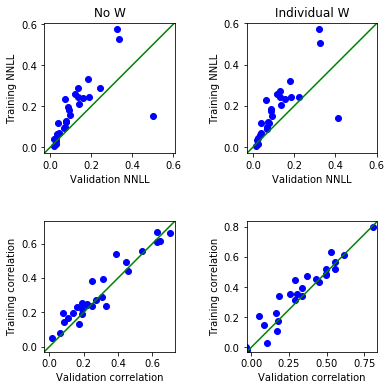

In [22]:
results_indiv = np.load('driftinggs_indivfit_sm.npz')
results_noW = np.load('driftinggs_noW_sm.npz')

fig,axes = plt.subplots(ncols=2,nrows=2)

ax = axes[0,0]
(x,y) = (results_noW['val_losses'],results_noW['train_losses'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('No W')
ax.set_xlabel('Validation NNLL')
ax.set_ylabel('Training NNLL')

ax = axes[1,0]
(x,y) = (results_noW['val_corrs'],results_noW['train_corrs'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Validation correlation')
ax.set_ylabel('Training correlation')

ax = axes[0,1]
(x,y) = (results_indiv['val_losses'],results_indiv['train_losses'])
(x,y) = (x[x<1e6],y[y<1e6])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Individual W')
ax.set_xlabel('Validation NNLL')
ax.set_ylabel('Training NNLL')

ax = axes[1,1]
(x,y) = (results_indiv['val_corrs'],results_indiv['train_corrs'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Validation correlation')
ax.set_ylabel('Training correlation')


fig.tight_layout()
fig.set_size_inches(6,6)

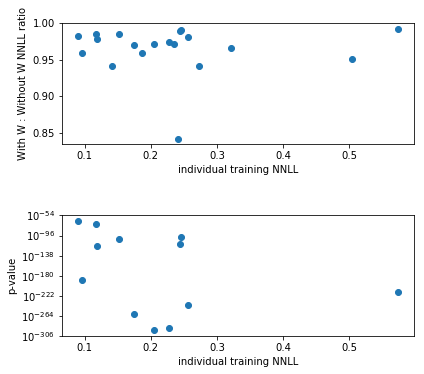

In [23]:
from scipy.stats import chi2
pvals = []
for i in range(results_indiv['devs'].size):
    pvals.append(chi2.sf((results_noW['devs'][i]-results_indiv['devs'][i]),df=d[1]))
pvals = np.array(pvals)
    
fig,axes = plt.subplots(ncols=1,nrows=2)
ax = axes[0]
ax.plot(results_indiv['train_losses'][results_indiv['conveds']==True],results_indiv['train_losses'][results_indiv['conveds']==True]/results_noW['train_losses'][results_indiv['conveds']==True],'o')
ax.set_xlabel('individual training NNLL')
ax.set_ylabel('With W : Without W NNLL ratio')
ax.axis('tight')

ax = axes[1]
ax.semilogy(results_indiv['train_losses'][results_indiv['conveds']==True],pvals[results_indiv['conveds']==True],'o')
ax.set_xlabel('individual training NNLL')
ax.set_ylabel('p-value')
ax.axis('tight')

fig.tight_layout()
fig.set_size_inches(6,6)

Next idea for fixing stimulus encoding: using a "pixel basis" for stimulus filters, but instead of encoding the trial start, encoding the stimulus as an impulse train with the same frequency as the stimulus, and filter length equal to the stimulus period. This encodes the temporal info in the stimulus representation, reducing the number of parameters, but still allows for more flexibility in the response than a small number of sinusoids. Concretely, the stimulus representation would be: 

\begin{equation}
  s^{(impulses)}_{j(t)}(t) =
    \begin{cases}
      1 & \text{if $(t-t_0)\%(1/f_{j(t)})\approx 0$}\\
      0 & \text{otherwise}
    \end{cases}       
\end{equation}

where, $j(t)$ is the index of the stimulus condition, $f_{j(t)}$ is the stimulus frequency in that condition, $t_0$ is the time of the start of the current trial, and $\%$ is the modulus operator.




$\textbf{Week of March 8:}$

Based on the continued evidence that the correlation in between the responses to drifting gratings and the frequency of the stimulus is confounding the parameter fits, I switched to using the static gratings. One thing to note is that the trial structure can still provide correlation between the response and the stimulus - if a neuron responds to the duration of a particular stimulus, then its spiking history will be correlated with that stimulus. Ultimately, I find it likely that trying a noisy stimulus and pre-determining the stimulus filter is the way to go, as long as using STA for the filter is ok.

Here's a quantification of the problem - the matrix of correlation coefficients for the predictors

In [24]:
K = 1 # number of harmonics
L = 2*K+1
conds = np.unique(stim,axis=1)  
mod_stim_sin = np.zeros((L*(conds.shape[1]-1),stim.shape[1]))
ind_old = -1
for t in range(stim.shape[1]):
    if stim[0,t]>0:
        ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
        if ind!=ind_old:
            t0=t
            ind_old=ind
        mod_stim_sin[(ind-1)*L,t] = 1
        for k in range(K):
            mod_stim_sin[(ind-1)*L+2*k+1,t] = np.cos(2.0*np.pi*(k+1)*stim[0,t]*(t-t0)*bin_len)
            mod_stim_sin[(ind-1)*L+2*k+2,t] = np.sin(2.0*np.pi*(k+1)*stim[0,t]*(t-t0)*bin_len)
        
    else:
        ind_old = -1
X_dsn = construct_Xdsn(mod_stim_sin,binned_spikes[ord_idxs[-1],:],d)


/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10


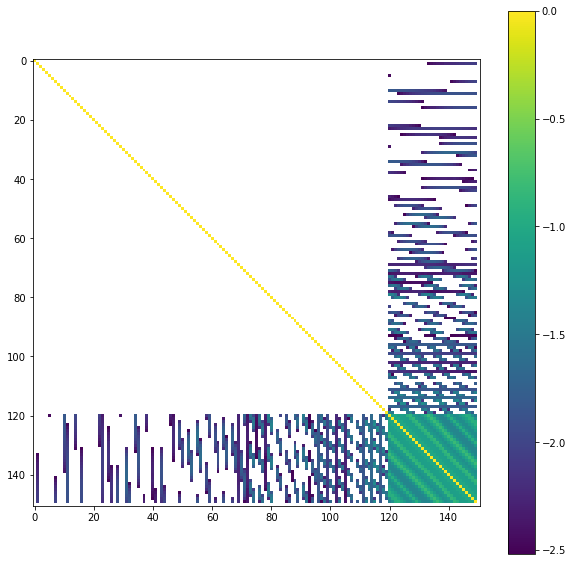

In [25]:
# plt.plot(conds[0,:])

fig,ax = plt.subplots()
x = np.corrcoef(X_dsn.T)
im = ax.imshow(np.where([(x>3e-3)],np.log10(x),np.nan).squeeze())
fig.colorbar(im)
fig.set_size_inches(10,10)


These are the self interaction filters that are fit individually to each neuron. Most of them look more normal, but there is still a sign of being confounded by the correlation between stimulus and response: the positive bump that could possibly be long term facilitation is probably actually a result of sustained firing during prefered trials.

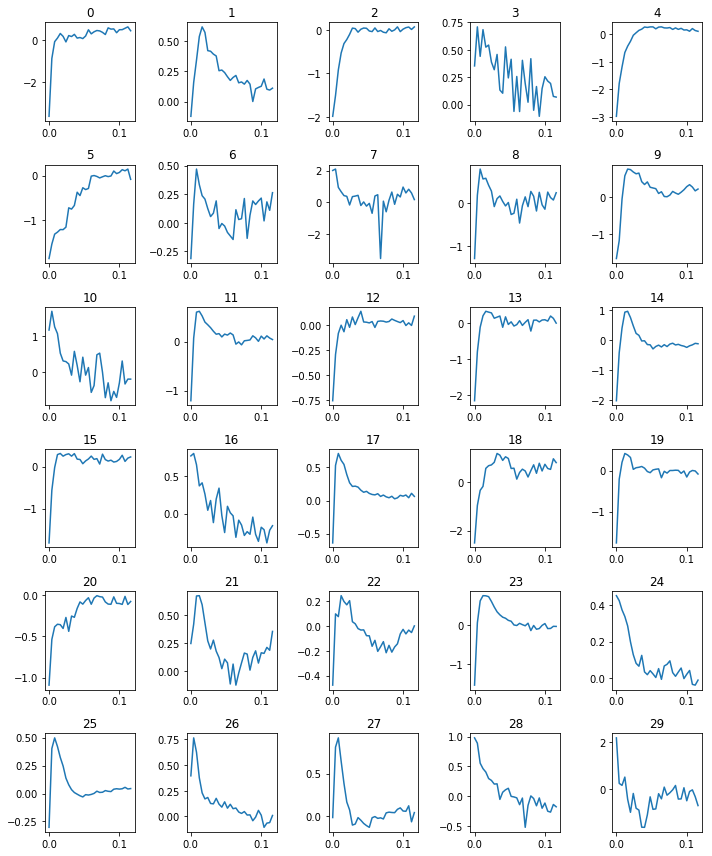

In [26]:
results_indiv = np.load('static_gratings_indivfit1.npz')

bin_len = 0.004
nr,nc = 6,5
fig,axes = plt.subplots(nrows=nr,ncols=nc)
W = results_indiv['W']
t = np.arange(d[1])*bin_len
for i in range(W.shape[0]):
    ax = axes[i/nc,i%nc]
    ax.plot(t,W[i,:])
    ax.set_title(i)
    
fig.set_size_inches(w=10,h=12)
fig.tight_layout()

These are the same plots of losses as with drifting gratings - at this point I've also implemented a convergence check.

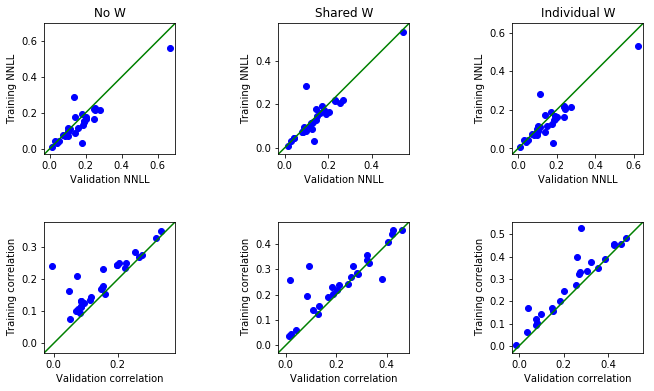

In [27]:
results_shared = np.load('static_gratings_shared1.npz')
results_noW = np.load('static_gratings_noW1.npz')
fig,axes = plt.subplots(ncols=3,nrows=2)

ax = axes[0,0]
(x,y) = (results_noW['val_losses'],results_noW['train_losses'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('No W')
ax.set_xlabel('Validation NNLL')
ax.set_ylabel('Training NNLL')

ax = axes[1,0]
(x,y) = (results_noW['val_corrs'],results_noW['train_corrs'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Validation correlation')
ax.set_ylabel('Training correlation')

ax = axes[0,1]
(x,y) = (results_shared['val_losses'],results_shared['train_losses'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Shared W')
ax.set_xlabel('Validation NNLL')
ax.set_ylabel('Training NNLL')

ax = axes[1,1]
(x,y) = (results_shared['val_corrs'],results_shared['train_corrs'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Validation correlation')
ax.set_ylabel('Training correlation')

ax = axes[0,2]
(x,y) = (results_indiv['val_losses'],results_indiv['train_losses'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Individual W')
ax.set_xlabel('Validation NNLL')
ax.set_ylabel('Training NNLL')

ax = axes[1,2]
(x,y) = (results_indiv['val_corrs'],results_indiv['train_corrs'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Validation correlation')
ax.set_ylabel('Training correlation')


fig.tight_layout()
fig.set_size_inches(10,6)

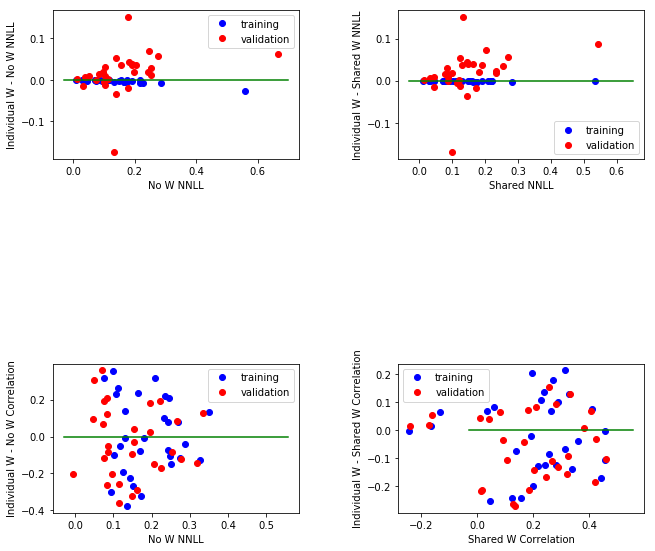

In [28]:
fig,axes = plt.subplots(ncols=2,nrows=2)

ax = axes[0,0]
(x1,y1) = (results_noW['train_losses'],results_indiv['train_losses'])
(x2,y2) = (results_noW['val_losses'],results_indiv['val_losses'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1-x1,'bo')
ax.plot(x2,y2-x1,'ro')
ax.plot(lims,[0,0],'g')
# ax.set_ylim([-0.01,0.01])
ax.set_xlabel('No W NNLL')
ax.set_ylabel('Individual W - No W NNLL')
ax.legend(['training','validation'])

ax = axes[1,0]
(x1,y1) = (results_noW['train_corrs'],results_indiv['train_corrs'])
(x2,y2) = (results_noW['val_corrs'],results_indiv['val_corrs'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1-x1,'bo')
ax.plot(x2,y2-x1,'ro')
ax.plot(lims,[0,0],'g')
ax.set_xlabel('No W NNLL')
ax.set_ylabel('Individual W - No W Correlation')
ax.legend(['training','validation'])

ax = axes[0,1]
(x1,y1) = (results_shared['train_losses'],results_indiv['train_losses'])
(x2,y2) = (results_shared['val_losses'],results_indiv['val_losses'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1-x1,'bo')
ax.plot(x2,y2-x1,'ro')
ax.plot(lims,[0,0],'g')
# ax.set_ylim([-0.01,0.01])
ax.set_xlabel('Shared NNLL')
ax.set_ylabel('Individual W - Shared W NNLL')
ax.legend(['training','validation'])

ax = axes[1,1]
(x1,y1) = (results_shared['train_corrs'],results_indiv['train_corrs'])
(x2,y2) = (results_shared['val_corrs'],results_indiv['val_corrs'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1-x1,'bo')
ax.plot(x2,y2-x1,'ro')
ax.plot(lims,[0,0],'g')
ax.set_xlabel('Shared W Correlation')
ax.set_ylabel('Individual W - Shared W Correlation')
ax.legend(['training','validation'])
fig.tight_layout()
fig.set_size_inches(10,10)

$\textbf{Week of March 15:}$

I had two main aims this week, trying the current analysis on natural movie data, in the hopes that the weak autocorrelation of the stimulus will allow the self interaction filter to reflect the true properties of the neural dynamics.

The other is doing an in-depth analysis of how and when this autocorrelation in the stimulus gives rise to contaminated self-interaction filters with simulation of known models.

In this first part, I look at the natural movies. It seems like they have much more biologically plausible self interaction filters, although most have a large part above zero, similar to, although less pronounced than with the drifting gratings. 

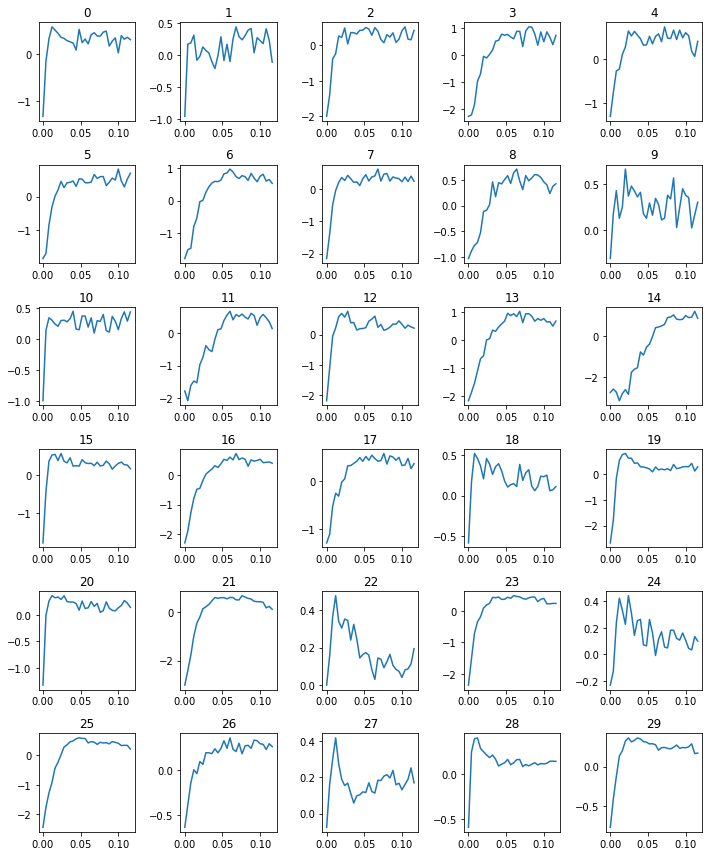

In [29]:
results_indiv = np.load('movie_indivfit2.npz')

bin_len = 0.004
nr,nc = 6,5
fig,axes = plt.subplots(nrows=nr,ncols=nc)
W = results_indiv['W']
t = np.arange(d[1])*bin_len
for i in range(W.shape[0]):
    ax = axes[i/nc,i%nc]
    ax.plot(t,W[i,:])
    ax.set_title(i)
    
fig.set_size_inches(w=10,h=12)
fig.tight_layout()

As before, there does not seem to be much overfitting, and accordingly reducing the number of parameters has a clear negative effect on the log likelihood. For some reason, the opposite seems to be true of the correlation: there is some sign of overfitting, and reducing the number of parameters seems to have a positive effect.

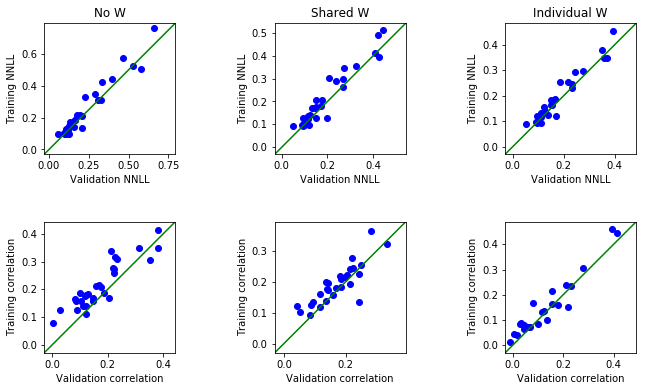

In [30]:
results_shared = np.load('movie_shared1.npz')
results_noW = np.load('movie_noW2.npz')

fig,axes = plt.subplots(ncols=3,nrows=2)

ax = axes[0,0]
(x,y) = (results_noW['val_losses'],results_noW['train_losses'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('No W')
ax.set_xlabel('Validation NNLL')
ax.set_ylabel('Training NNLL')

ax = axes[1,0]
(x,y) = (results_noW['val_corrs'],results_noW['train_corrs'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Validation correlation')
ax.set_ylabel('Training correlation')

ax = axes[0,1]
(x,y) = (results_shared['val_losses'],results_shared['train_losses'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Shared W')
ax.set_xlabel('Validation NNLL')
ax.set_ylabel('Training NNLL')

ax = axes[1,1]
(x,y) = (results_shared['val_corrs'],results_shared['train_corrs'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Validation correlation')
ax.set_ylabel('Training correlation')

ax = axes[0,2]
(x,y) = (results_indiv['val_losses'],results_indiv['train_losses'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Individual W')
ax.set_xlabel('Validation NNLL')
ax.set_ylabel('Training NNLL')

ax = axes[1,2]
(x,y) = (results_indiv['val_corrs'],results_indiv['train_corrs'])
lims = [-0.03,max(np.max(x),np.max(y))+0.03]
ax.plot(x,y,'bo')
ax.plot(lims,lims,'g')
ax.axis('square')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Validation correlation')
ax.set_ylabel('Training correlation')


fig.tight_layout()
fig.set_size_inches(10,6)

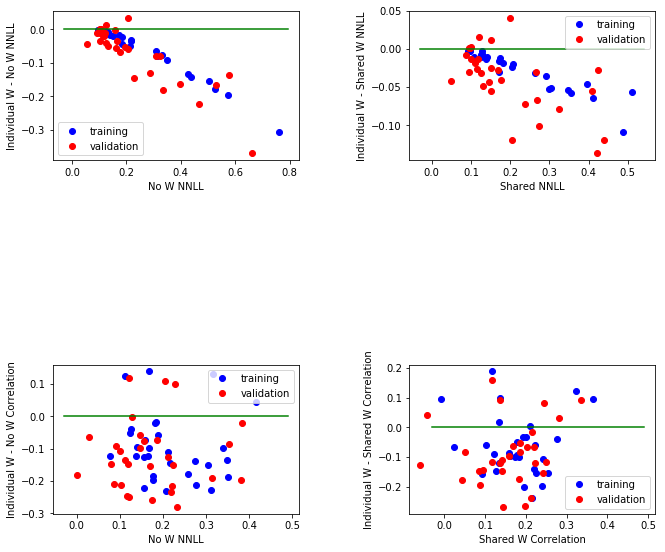

In [31]:
fig,axes = plt.subplots(ncols=2,nrows=2)

ax = axes[0,0]
(x1,y1) = (results_noW['train_losses'],results_indiv['train_losses'])
(x2,y2) = (results_noW['val_losses'],results_indiv['val_losses'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1-x1,'bo')
ax.plot(x2,y2-x1,'ro')
ax.plot(lims,[0,0],'g')
# ax.set_ylim([-0.001,0.001])
ax.set_xlabel('No W NNLL')
ax.set_ylabel('Individual W - No W NNLL')
ax.legend(['training','validation'])

ax = axes[1,0]
(x1,y1) = (results_noW['train_corrs'],results_indiv['train_corrs'])
(x2,y2) = (results_noW['val_corrs'],results_indiv['val_corrs'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1-x1,'bo')
ax.plot(x2,y2-x1,'ro')
ax.plot(lims,[0,0],'g')
ax.set_xlabel('No W NNLL')
ax.set_ylabel('Individual W - No W Correlation')
ax.legend(['training','validation'])

ax = axes[0,1]
(x1,y1) = (results_shared['train_losses'],results_indiv['train_losses'])
(x2,y2) = (results_shared['val_losses'],results_indiv['val_losses'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1-x1,'bo')
ax.plot(x2,y2-x1,'ro')
ax.plot(lims,[0,0],'g')
# ax.set_ylim([-0.01,0.01])
ax.set_xlabel('Shared NNLL')
ax.set_ylabel('Individual W - Shared W NNLL')
ax.legend(['training','validation'])

ax = axes[1,1]
(x1,y1) = (results_shared['train_corrs'],results_indiv['train_corrs'])
(x2,y2) = (results_shared['val_corrs'],results_indiv['val_corrs'])
lims = [-0.03,max(np.max(x1),np.max(y1),np.max(x2),np.max(y2))+0.03]
ax.plot(x1,y1-x1,'bo')
ax.plot(x2,y2-x1,'ro')
ax.plot(lims,[0,0],'g')
ax.set_xlabel('Shared W Correlation')
ax.set_ylabel('Individual W - Shared W Correlation')
ax.legend(['training','validation'])
fig.tight_layout()
fig.set_size_inches(10,10)

This next part shows my attempts to understand when properties of the stimulus bleed into the self-interaction filter. The main result is that I was unable to see this effect when fitting to data from an exact GLM model, but was able to see something when corrupting the firing rate with temporally coordinated noise (in this case, just zeroing out intervals).

In [32]:
# #helper functions for fitting GLM models
# from scipy.stats import pearsonr
# from scipy.misc import factorial

# def construct_Xdsn(flat_stimulus, binned_spikes, d):
#     T = binned_spikes.size # T is number of time bins
#     (M,T1) = flat_stimulus.shape # M is the size of a stimulus
    
#     assert T==T1, "arrays have different number of time samples"
#     d1,d2 = d
#     dmax = max(d)
#     binned_spikes = np.concatenate((np.zeros((dmax,)),binned_spikes))
#     flat_stimulus = np.concatenate((np.zeros((M,dmax)),flat_stimulus),axis=1)
#     T = binned_spikes.size
#     X_dsn = np.ones((T-dmax,M*d1+d2+1))
#     for t in range(T-dmax):
#         X_dsn[t,:M*d1] = np.flip(flat_stimulus[:,t+dmax+1-d1:t+dmax+1],axis=1).reshape((1,-1))  #stimulus inputs
#         X_dsn[t,M*d1:-1] = np.flip(binned_spikes[t+dmax-d2:t+dmax],axis=0).reshape((1,-1)) #spike inputs
#     return X_dsn

# def fit_GLM(stim,spks,d,val_stim=None,val_spks=None):
#     d1,d2 = d
#     dmax = max(d)
#     y = spks.reshape([-1,1])
#     model =  sm.GLM(y,construct_Xdsn(stim,spks,d),family = sm.families.Poisson())
#     m_it = 200 #24
#     model_results = model.fit(maxiter=m_it)
# #     print model_results.fit_history['iteration']
#     conved = m_it!=model_results.fit_history['iteration']
#     p = model_results.params
#     se = model_results.bse
#     b = p[-1]
#     bse = se[-1]
#     stim_filt = p[:-1-d2]
#     stim_se = se[:-1-d2]
#     spk_filt = p[-1-d2:-1]
#     spk_se = se[-1-d2:-1]
    
#     t_filt = np.arange(-6,7)
#     sig = 1.5
#     filt = np.exp(-np.square(t_filt)/(sig**2*2))
#     filt = filt/np.sum(filt)
    
#     train_nnll = -model_results.llf/(spks.shape[-1]-dmax)
#     smooth_spks = np.convolve(spks,filt,mode='same')
#     train_corr = pearsonr(model.predict(p),smooth_spks)[0]
#     dev = model_results.deviance
# #     print dev, 2*(np.sum(-y+y*np.log(y+1e-20)-np.log(factorial(y)))-model_results.llf)
#     if val_stim is not None:
#         val_model = sm.GLM(val_spks.reshape([-1,1]),construct_Xdsn(val_stim,val_spks,d),family = sm.families.Poisson())
#         val_nnll = -val_model.loglike(p)/(spks.shape[-1]-dmax)
#         smooth_val_spks = np.convolve(val_spks,filt,mode='same')
#         val_corr = pearsonr(val_model.predict(p),smooth_val_spks)[0]
#         return stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr, val_nnll, val_corr, dev, conved
#     return stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr, dev, conved

# def sim_GLM(stim, stim_filt, spk_filt, offset,noise=None,drop_rate = None, drop_len = None):
#     d = (stim_filt.shape[-1], spk_filt.size)
#     T = stim.shape[1]
#     spks = np.zeros((T,)) # starts at time step d
#     rate = np.zeros((T,))
#     for i in range(max(d),T):
#         rate[i] = np.exp((np.flip(stim_filt,-1).reshape(1,-1)).dot((stim[:,i-d[0]+1:i+1].reshape(-1,1)))+np.flip(spk_filt,0).dot(spks[i-d[1]:i])+offset)
#         if noise is not None:
#             rate[i] = max(0,rate[i]*np.random.normal(loc=1.0,scale=noise))
#         if drop_rate is None:
#             spks[i] = np.random.poisson(rate[i])
#         else:
#             if drop_len is None:
#                 spks[i] = np.random.poisson(rate[i])*(np.random.uniform()>drop_rate)
#             else:
#                 spks[i] = np.random.poisson(rate[i])
#                 if (np.random.uniform()<drop_rate/drop_len):
#                     spks[max(0,i+1-drop_len):i+1] = 0
#     return spks, rate



(120, 1)


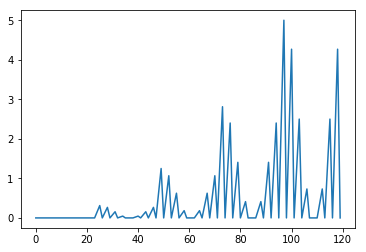

In [33]:
# pre-specified model parameters
t_f = np.arange(d[1])
spk_filt = -1*np.exp(-t_f)
b = -4

z = np.array([0.5,1,0])
x = np.square(np.arange(5))
y = 1+np.cos(2*np.pi*np.arange(8)/8)
x = np.expand_dims(x,1)
y = np.expand_dims(y,0)
z = np.expand_dims(z,0)
stim_filt = (np.expand_dims(x.dot(y),2).dot(z)).reshape([-1,1])
stim_filt *= 5.0/np.max(stim_filt)
plt.plot(stim_filt.squeeze())
print stim_filt.shape

In [36]:
# simulate the model and try to fit the parameters back

T = binned_spikes.shape[1]
bin_len = 0.01
### drifting gratings
train_inds = np.concatenate((np.arange(int(600/bin_len)),np.arange(int(1600/bin_len),1+int(2200/bin_len))))
val_inds = np.arange(int(3200/bin_len),T)

d=[1,30]
spks, rate = sim_GLM(mod_stim_sin,stim_filt,spk_filt,b,drop_rate = 0.05, drop_len = 50)
stim_filt_fit, spk_filt_fit, b_fit, stim_se, spk_se, b_se, train_nnll, train_corr, dev, conved = fit_GLM(mod_stim_sin[:,train_inds],spks[train_inds],d)

17846.0  spikes
true offset =  -4  fit offset =  -4.103160704010065  +/-  0.037113270547764476


/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


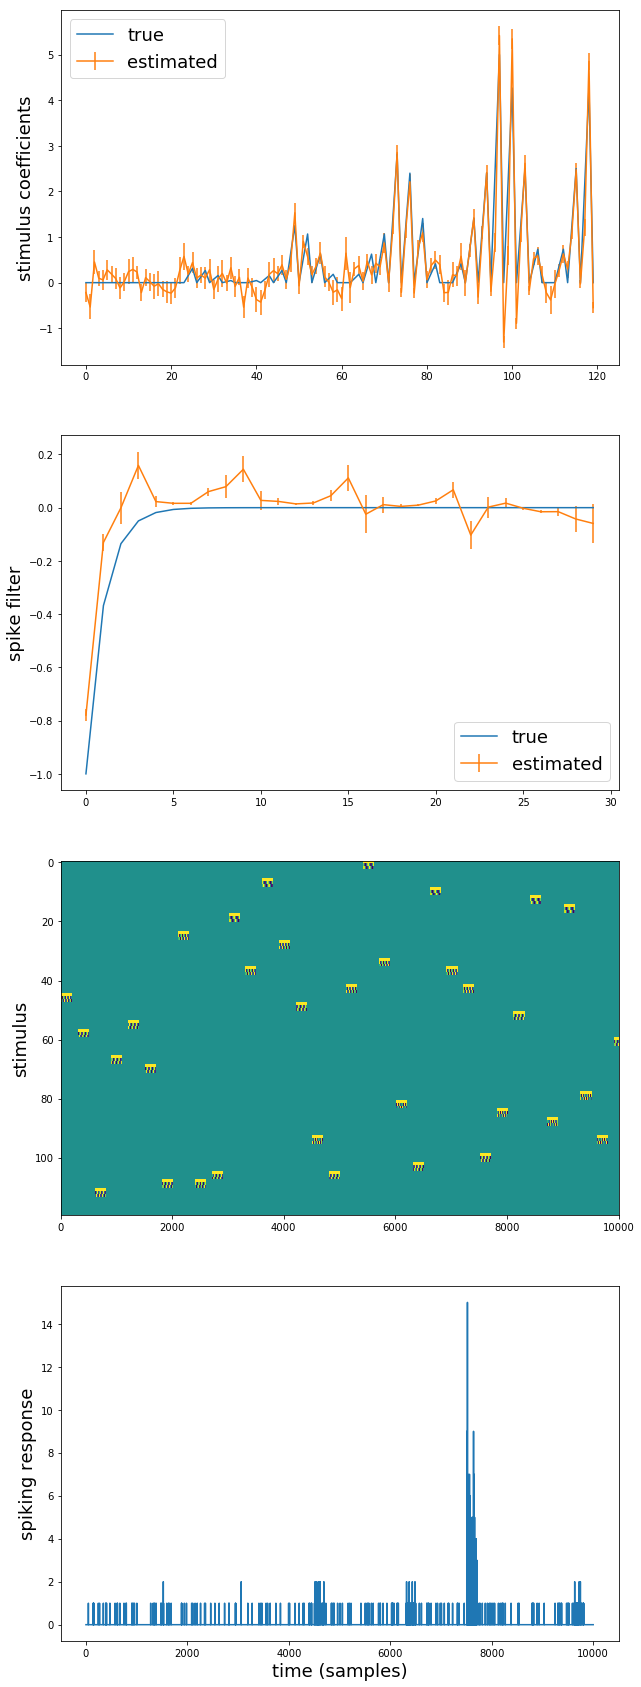

In [37]:
plt.subplots(figsize=(10,30))
plt.subplot(4,1,1)
# plt.imshow(stim_filt.reshape((5,8,3))[:,:,0],label='true')
plt.plot(stim_filt,label='true')
plt.subplot(4,1,2)
plt.plot(spk_filt,label='true')

print np.sum(spks), ' spikes'
plt.subplot(4,1,3)
plt.imshow(mod_stim_sin[:,:10000])
plt.axis('tight')
plt.ylabel('stimulus',fontsize=18)
plt.subplot(4,1,4)
plt.plot(spks[:10000])
plt.ylabel('spiking response',fontsize=18)
plt.xlabel('time (samples)',fontsize=18)

plt.subplot(4,1,1)
plt.errorbar(np.arange(stim_filt_fit.size),stim_filt_fit,yerr=stim_se,label='estimated')
plt.ylabel('stimulus coefficients',fontsize=18)
plt.legend(fontsize=18)
plt.subplot(4,1,2)
plt.errorbar(np.arange(spk_filt_fit.size),spk_filt_fit,yerr=spk_se,label='estimated')
plt.ylabel('spike filter',fontsize=18)
plt.legend(fontsize=18)
print 'true offset = ', b, ' fit offset = ', b_fit, ' +/- ', b_se

# rmse_stim_filt = np.sqrt(np.mean(np.square(stim_filt_fit-stim_filt)))
# print 'stimulus filter rmse = ', rmse_stim_filt
# rmse_spk_filt = np.sqrt(np.mean(np.square(spk_filt_fit[spk_filt>-2.5]-spk_filt[spk_filt>-2.5])))
# print 'spike filter rmse = ', rmse_spk_filt

$\textbf{Week of April 5}$

I implemented a calculation of the "PSTH histogram" prediction version of a correlation metric, as in Pillow & Paninski 2008. I didn't go back and calculate it on any of the entire datasets, but for some example neurons I checked it on the r-value was very high, around 0.97

I also worked on the process of initializing model parameters with the Spike Triggered Average, instead of simply fixing the filter as a scaled STA. The results do not converge to a very different log likelihood, but the resulting stimulus filter looks much smoother (as shown below). This makes me think that in general, for convergence, I should be monitoring parameters, not log-likelihood, and also suggests that indeed, using the STA to initialize results in faster convergence.

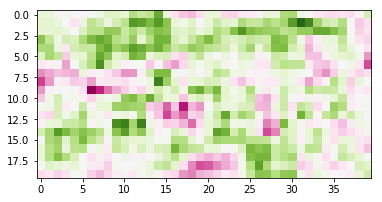

In [38]:
D = np.load('init_sta_exF.npz')
F = D['F']
m = max(np.max(np.max(F)),-np.min(np.min(F)))
plt.imshow(F.reshape(20,40),cmap='PiYG',vmin=-m,vmax=m)

Continuing with the effort to understand how the autocorrelation of the stimulus can contaminate the self-interaction filter, I modified the unmodeled noise in the simulated data to be filtered gaussian noise that is added to the rate. Below shows the recovery of the self-interaction filter over a range of noise amplitudes and widths of the gaussian kernel used to filter the noise.

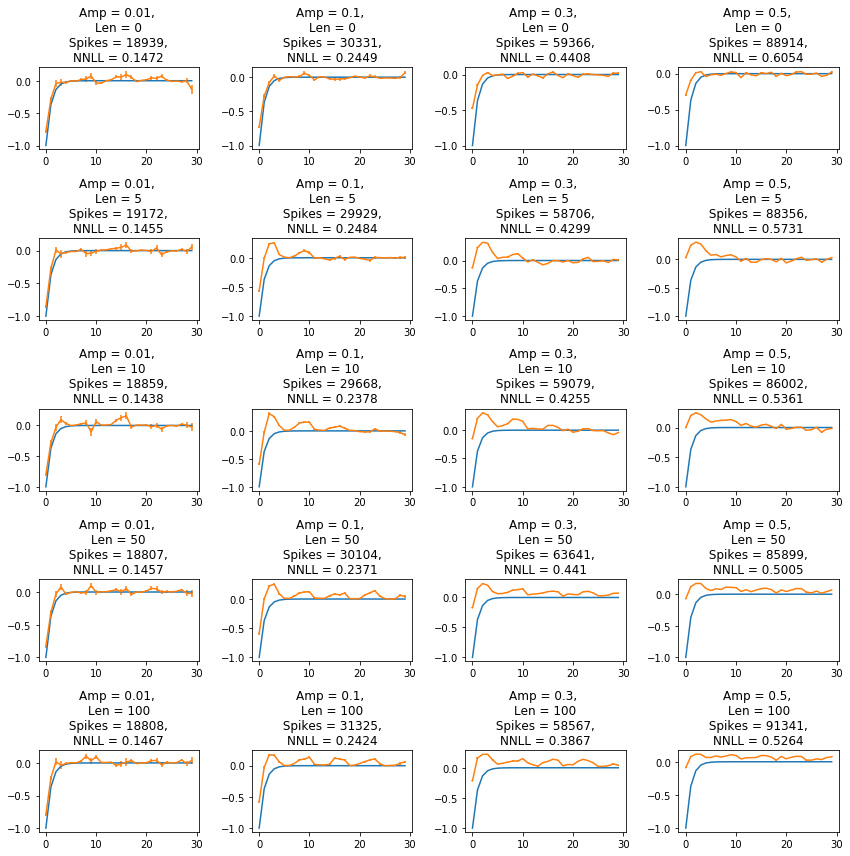

In [39]:
noise_amps = [0.01,0.1,0.3,0.5]
noise_lens = [0,5,10,50,100]

nc,nr = len(noise_amps),len(noise_lens)
fig,axes = plt.subplots(nrows=nr,ncols=nc)
for c,noise_amp in enumerate(noise_amps):
    for r,noise_len in enumerate(noise_lens):
        spks, rate = sim_GLM(mod_stim_sin,stim_filt,spk_filt,b,noise_amp=noise_amp,noise_len=noise_len)
        stim_filt_fit, spk_filt_fit, b_fit, stim_se, spk_se, b_se, train_nnll, train_corr, dev, conved = fit_GLM(mod_stim_sin[:,train_inds],spks[train_inds],d)
        axes[r,c].plot(spk_filt,label='true')
        axes[r,c].errorbar(np.arange(spk_filt_fit.size),spk_filt_fit,yerr=spk_se,label='estimated')
        axes[r,c].set_title('Amp = '+str(noise_amp)+', \nLen = '+str(noise_len)+'\n Spikes = '+str(int(np.sum(spks)))+', \nNNLL = '+str(np.round(train_nnll,decimals=4)))

fig.set_size_inches(w=12,h=12)
fig.tight_layout()

$\textbf{Weeks of April 12 and April 19}$

This week, I focused my attention on the original parameter sharing problem, bypassing the parameter contamination problem by using the In-Vitro Single-Cell Characterization (IVSCC) dataset, whose stimulus is a pink noise injected current (minimal autocorrelation), and whose cells are isolated (minimal noise in the system).

My first goal was to affirm that it even makes sense to cluster the self-interaction filters of different cells (fit individually) - i.e. that the filters are clean and sufficiently different that it makes sense to have more than one cluster. I also looked at whether the clusters are meaningful in the sense that they are invariant to the exact input data used.

[[ 6  6  1 33  0  0  1  1]
 [ 4  0 81  0  0  0  0  0]
 [ 0  0  0  0  1  2  2  0]
 [66  0 23  3  0  0  0  0]
 [ 0 17  0  4  5  0  0  0]
 [ 0  4  0  2 12  2  0  1]
 [ 0  0  0  0  1  1  3  1]
 [ 0  0  0  0  1  1  2  3]]
0.571232098647


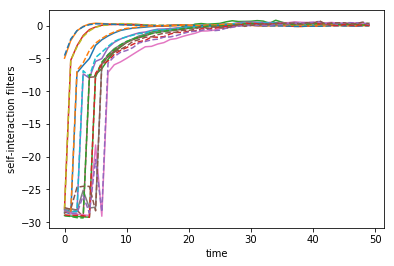

In [66]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score

D1 = np.load('ivscc_indiv_half_tv.npz')
D2 = np.load('ivscc_indiv_other_half_tv.npz')
nc=8

kmeans = KMeans(n_clusters=nc).fit(D1['Ws'])
labels1 = kmeans.labels_
centers1 = kmeans.cluster_centers_.T

kmeans = KMeans(n_clusters=nc).fit(D2['Ws'])
labels2 = kmeans.labels_
centers2 = kmeans.cluster_centers_.T

plt.plot(centers1)
plt.plot(centers2,'--')
plt.xlabel('time')
plt.ylabel('self-interaction filters')
print confusion_matrix(labels1,labels2)
print adjusted_rand_score(labels1,labels2)

From the above cell, it is evident that the clusters of self interaction filters are distinct and consistent: the filters corresponding to the different clusters are different from each other, but change minimally when fit on the other half of the data (the cluster centers are almost identical, and membership is very similar, as seen from the confusion matrix and high adjusted rand score). Not shown: the adjusted rand score is very near 0.57-0.6 for any number of clusters between 3-10.

Next, I use these cluster memberships to share self-interaction filters during fitting and evaluate based on the change in validation likelihood. As a control, I also do this with shuffled cluster memberships, to see whether any improvements are coming from the particular clusters, or if any sharing works just as well as a regularizer.

[0.05430333 0.04554252 0.04309423 0.08801224 0.05286168 0.04062384
 0.07656172 0.07804365 0.03867916 0.04243432 0.03937285 0.06731458
 0.09470812 0.07565317 0.01675701 0.11338279 0.07133424 0.03727149
 0.1522948  0.12293382 0.06580624 0.10746009 0.12690414 0.07526008
 0.16446841 0.03718797 0.13819361 0.07745205 0.09248408 0.14228564
 0.13763665 0.05822318 0.09317196 0.06399127 0.0652012  0.08823619
 0.05453282 0.04979345 0.04484842 0.05913878 0.0523233  0.15621954
 0.05282822 0.04457007 0.05926123 0.0385802  0.12829379 0.04672636
 0.04468543 0.04957347 0.05850477 0.05931572 0.15526287 0.04871808
 0.05092717 0.15637821 0.06622365 0.09298887 0.04351972 0.06231996
 0.08006586 0.08562136 0.09472293 0.07684301 0.19080932 0.01500033
 0.05972019 0.11627541 0.05495651 0.08761262 0.01835543 0.05571819
 0.04477576 0.07703445 0.07889877 0.15281328 0.06320996 0.06202099
 0.11053567 0.36236379 0.07441136 0.05289144 0.0921215  0.06583212
 0.11028861 0.14308521 0.07835098 0.32233653 0.08991666 0.0041

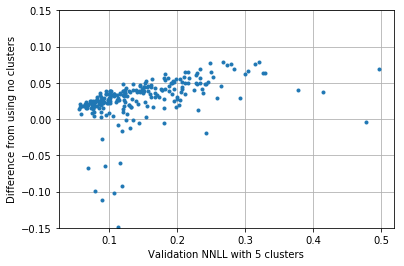

In [2]:
D_cl3 = np.load('ivscc_clustered_half_tv.npz')
D_cl5 = np.load('ivscc_clustered_half_tv_5cls.npz')
D_cl3_rand = np.load('ivscc_clustered_half_tv_random_labels.npz')
D_cl5_rand = np.load('ivscc_clustered_half_tv_5cls_random_labels.npz')
D_ind = np.load('ivscc_indiv_half_tv.npz')
D_ind2 = np.load('ivscc_indiv_other_half_tv.npz')

print D_ind['train_losses']

x=D_cl5['val_losses']
y=D_ind['val_losses']
plt.plot(x,x-y,'.')
plt.ylim([-0.15,0.15])
plt.xlabel('Validation NNLL with 5 clusters')
plt.ylabel('Difference from using no clusters')
plt.grid()

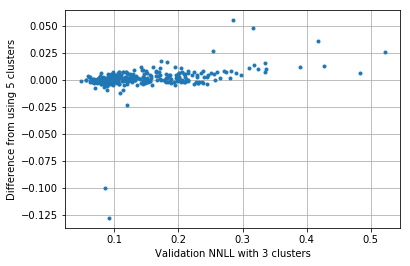

In [36]:
x=D_cl3['val_losses']
y=D_cl5['val_losses']
plt.plot(x,x-y,'.')
plt.xlabel('Validation NNLL with 3 clusters')
plt.ylabel('Difference from using 5 clusters')
plt.grid()

This above comparison is just showing that increasing the number of clusters from 3 to 5 definitley improves validation loss, so possibly more clusters would help further.

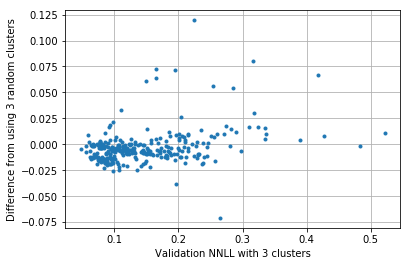

In [37]:
x=D_cl3['val_losses']
y=D_cl3_rand['val_losses']
plt.plot(x,x-y,'.')
plt.xlabel('Validation NNLL with 3 clusters')
plt.ylabel('Difference from using 3 random clusters')
plt.grid()

The above shows that with 3 clusters, most cells have lower validation loss when using the "true" clusters over random ones, but that there are plenty that do better with the random clusters.

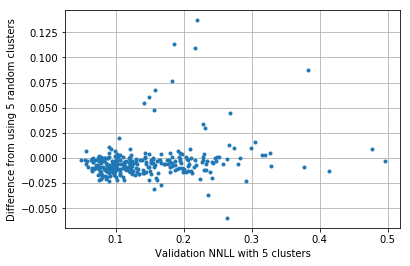

In [38]:
x=D_cl5['val_losses']
y=D_cl5_rand['val_losses']
plt.plot(x,x-y,'.')
plt.xlabel('Validation NNLL with 5 clusters')
plt.ylabel('Difference from using 5 random clusters')
plt.grid()

With 5 clusters, the effect of the k-means clusters outperforming random clusters seems even more pronounced, although there are still a few neurons that do much better with the random clusters. Below, we see that the individually fit filters for these few neurons are relatively jagged and have higher standard errors (see plot below of 8 arbitrary neurons' filters for comparison), indicating worse fits, and likely leading to an incorrect assignment during clustering.

Hopefully, this is the sort of thing that would be avoided by an E-M procedure.

Text(0.5,1,'self interaction filters of neurons that \n performed better when clustered randomly')

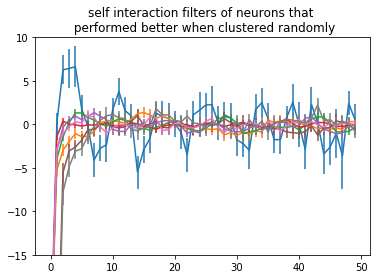

In [39]:
inds = np.nonzero(D_cl5['val_losses']>0.05+D_cl5_rand['val_losses'])[0]
for i in inds:
    plt.errorbar(np.arange(50),D_ind['Ws'][i,:],yerr=D_ind['Wses'][i,:]*(D_ind['Wses'][i,:]<1e3))
plt.ylim([-15,10])
plt.title('self interaction filters of neurons that \n performed better when clustered randomly')

(-15, 10)

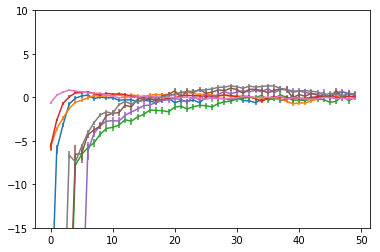

In [40]:
for i in range(8):
    plt.errorbar(np.arange(50),D_ind['Ws'][i,:],yerr=D_ind['Wses'][i,:]*(D_ind['Wses'][i,:]<1e3))
plt.ylim([-15,10])

In [41]:
D = np.load('ivscc_data_half_tv.npz')
binned_spikes = D['binned_spikes']
stim = D['binned_stim']
bin_len = D['bin_len']
print bin_len
print stim.shape
max_cl = 100
dd = 6
X_test = np.ones([max_cl*stim.shape[1]/2,dd*max_cl])


0.002
(290, 36048)


In [67]:
def construct_Xdsn_shared(flat_stimulus, binned_spikes, d, shared_stim):
    (N,T) = binned_spikes.shape # T is number of time bins
    sh = flat_stimulus.shape # M is the size of a stimulus
    if len(sh)==1:
        M = 1
        T1 = sh[0]
        flat_stimulus = np.expand_dims(flat_stimulus,axis=0)
    else:
        (M,T1) = sh 
        
    assert T==T1, "arrays have different number of time samples"
    d1,d2 = d
    dmax = max(d)
    binned_spikes = np.concatenate((np.zeros((N,dmax)),binned_spikes),axis=1)
    flat_stimulus = np.concatenate((np.zeros((M,dmax)),flat_stimulus),axis=1)
    T += dmax
    if not shared_stim:
            M=1
            
    X_dsn = np.zeros(((T-dmax)*N,M*d1*N+d2+1))
    y_dsn = np.zeros(((T-dmax)*N,1))
    for t in range(T-dmax):
        for n in range(N):
            if shared_stim:
                X_dsn[n*(T-dmax)+t,n*M*d1:(n+1)*M*d1] = np.flip(flat_stimulus[:,t+dmax+1-d1:t+dmax+1],axis=1).reshape((1,-1))  #stimulus inputs
            else:
                X_dsn[n*(T-dmax)+t,n*M*d1:(n+1)*M*d1] = np.flip(flat_stimulus[n,t+dmax+1-d1:t+dmax+1],axis=0).reshape((1,-1))  #stimulus inputs
            X_dsn[n*(T-dmax)+t,N*M*d1:-1] = np.flip(binned_spikes[n,t+dmax-d2:t+dmax],axis=0).reshape((1,-1)) #spike inputs
            X_dsn[n*(T-dmax)+t,-1] = 1.0 #constant term
            y_dsn[n*(T-dmax)+t] = binned_spikes[n,t+dmax]
    return X_dsn, y_dsn

def fit_GLM_shared(stim,spks,d,val_stim=None,val_spks=None,trial_inds=None,cond_inds=None,val_trial_inds=None,val_cond_inds=None,trial_len=None,shared_stim=True):
    d1,d2 = d
    dmax = max(d)
    X,y = construct_Xdsn_shared(stim,spks,d, shared_stim)
    model =  sm.GLM(y,X,family = sm.families.Poisson())
    m_it = 200 #24
    model_results = model.fit(maxiter=m_it)
#     print model_results.fit_history['iteration']
    conved = m_it!=model_results.fit_history['iteration']
    p = model_results.params
    se = model_results.bse
    b = p[-1]
    bse = se[-1]
    stim_filts = p[:-1-d2].reshape([spks.shape[0],-1,d1])
    stim_se = se[:-1-d2].reshape([spks.shape[0],-1,d1])
    spk_filt = p[-1-d2:-1]
    spk_se = se[-1-d2:-1]
    
    train_nnlls = np.zeros((N,))
    train_corrs = np.zeros((N,))
    val_nnlls = np.zeros((N,))
    val_corrs = np.zeros((N,))
    
    for n in range(N):
        pn = np.concatenate((p[n*M*d1:(n+1)*M*d1],p[-1-d2:]))
        if shared_stim:
            model_t = sm.GLM(spks[n,:].reshape([-1,1]),construct_Xdsn(stim,spks[n,:],d),family = sm.families.Poisson())
        else:
            model_t = sm.GLM(spks[n,:].reshape([-1,1]),construct_Xdsn(stim[n,:],spks[n,:],d),family = sm.families.Poisson())
    
        train_nnlls[n] = -model_t.loglike(pn)/(spks.shape[-1]-dmax)
        if trial_len is not None:
            num_conds = np.unique(cond_inds).size
            mean_resps = np.empty((trial_len,num_conds))
            for i in range(num_conds):
                for t in range(trial_len):
                    mean_resps[t,i] = np.mean(spks[trial_inds[cond_inds==i]+t])

            N_samps = 30
            exp_resps = np.zeros((trial_len,num_conds))
            for n in range(N_samps):
                sim_spks,_ = sim_GLM(stim, stim_filt, spk_filt, b)
                for i in range(num_conds):
                    for t in range(trial_len):
                        exp_resps[t,i] += np.mean(sim_spks[trial_inds[cond_inds==i]+t])
            exp_resps /= N_samps
            train_corrs[n] = pearsonr(mean_resps.reshape([-1,1]),exp_resps.reshape([-1,1]))[0]
        else:
            smooth_spks = np.convolve(spks,filt,mode='same')
            train_corrs[n] = pearsonr(model.predict(pn),smooth_spks)[0]
            


        if val_stim is not None:
            if shared_stim:
                val_model = sm.GLM(val_spks[n,:].reshape([-1,1]),construct_Xdsn(val_stim,val_spks[n,:],d),family = sm.families.Poisson())
            else:
                val_model = sm.GLM(val_spks[n,:].reshape([-1,1]),construct_Xdsn(val_stim[n,:],val_spks[n,:],d),family = sm.families.Poisson())
            val_nnlls[n] = -val_model.loglike(pn)/(spks.shape[-1]-dmax)
            smooth_val_spks = np.convolve(val_spks,filt,mode='same')
            val_corrs[n] = pearsonr(val_model.predict(pn),smooth_val_spks)[0]
    if val_stim is not None:
        return stim_filts, spk_filt, b, stim_se, spk_se, bse, train_nnlls, train_corrs, val_nnlls, val_corrs, conved
    return stim_filts, spk_filt, b, stim_se, spk_se, bse, train_nnlls, train_corrs, conved


In [69]:
import gc
D = np.load('ivscc_data_half_tv.npz')
binned_spikes = D['binned_spikes']
stim = D['binned_stim']
bin_len = D['bin_len']
tv_split = 1.0/2
train_inds = np.arange(int(stim.shape[1]*tv_split))
val_inds = np.arange(int(stim.shape[1]*tv_split),int(stim.shape[1]))
cell_types = labels1

d = [1,30]
(d1,d2) = d


N = stim.shape[0]
classes = np.unique(cell_types)
train_nnlls = np.zeros((N,))
train_corrs = np.zeros((N,))
val_nnlls = np.zeros((N,))
val_corrs = np.zeros((N,))
Fs = np.zeros((N,d1))
Ws = np.zeros((classes.size,d2))
bs = np.zeros((N,))
Fses = np.zeros((N,d1))
Wses = np.zeros((classes.size,d2))
bses = np.zeros((N,))

for c,cls in enumerate(classes):
    cls_inds = np.nonzero(cell_types==cls)[0]
    print c,cls, cls_inds.size
    gc.collect()
    stim_filts, spk_filt, b, stim_se, spk_se, bse, tnnlls, tcorrs, vnnlls, vcorrs, conved = fit_GLM_shared(stim[cls_inds,:][:,train_inds],binned_spikes[cls_inds,:][:,train_inds],d,val_stim = stim[cls_inds,:][:,val_inds], val_spks = binned_spikes[cls_inds,:][:,val_inds],shared_stim=False)
    if not conved:
        print 'Class ',cls, ' Failed'
        
    Ws[c,:] = spk_filt
    Wses[c,:] = spk_se
    Fs[cls_inds,:] = stim_filts
    Fses[cls_inds,:] = stim_se
    bs[cls_inds,:] = b
    bses[cls_inds,:] = bse
    bs[cls_inds,:] = b
    train_nnlls[cls_inds,:] = tnnlls
    train_corrs[cls_inds,:] = tcorrs
    val_nnlls[cls_inds,:] = vnnlls
    val_corrs[cls_inds,:] = vcorrs
    

0 0 48


MemoryError: 